# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

# for image loading
from tensorflow.keras.utils import load_img, save_img
from tensorflow.keras.preprocessing.image import img_to_array
# for CNN model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

import glob
import os
import time
import pickle

from colorama import Fore, Style

from tensorflow.keras import Model, models

2022-09-07 23:17:16.586908: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-07 23:17:16.688043: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 23:17:16.688058: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Posibilities to impove Model
* Train with larger picture size
* Get more pictures
* Try other models like VGG 16, or  EfficientNet or Train ourselfe a model
* Optimize the model parameters
* Data Augmentation

# Loading Data

## Access data locally

In [2]:
# define the path of the picture categories
data_path = os.path.join("..","raw_data","living-room-categories","train_data" )
data_path

'../raw_data/living-room-categories/train_data'

In [3]:
categories = os.listdir(data_path)
categories

['traditional',
 'elestic',
 'industrial',
 'midcentury',
 'asian',
 'farmhouse',
 'mediterranean',
 'modern',
 'scandinavian']

## Create DataFrames

### Train Data-Frame

In [4]:
# Only with jpg now - if we want other picture tpyes we have to include them

result = []
for cat in categories:
    #filter out system files
    if not cat.startswith("."): 
        print(cat)
        cat_path = os.path.join(data_path,cat)
        for pic in os.listdir(cat_path):
            if pic.endswith(".jpg"):
                path_complete = os.path.join(cat_path,pic)
                result.append({"pic-name": f"{pic}", "pic-path":f"{path_complete}", "category": f"{cat}"})

df_train =pd.DataFrame(result)

traditional
elestic
industrial
midcentury
asian
farmhouse
mediterranean
modern
scandinavian


In [5]:
# Head of Dataframe
df_train.head()

,pic-name,pic-path,category
0,biltmore-ballroom-marker-construction-group-im...,../raw_data/living-room-categories/train_data/...,traditional
1,beverly-hills-pied-a-terre-john-de-bastiani-in...,../raw_data/living-room-categories/train_data/...,traditional
2,leawood-residence-tobi-fairley-interior-design...,../raw_data/living-room-categories/train_data/...,traditional
3,living-room-the-house-designers-img_b5b11e050f...,../raw_data/living-room-categories/train_data/...,traditional
4,Αντίγραφο του chelmsford-road-dennis-mayer-pho...,../raw_data/living-room-categories/train_data/...,traditional


In [6]:
df_train.shape

(10921, 3)

In [7]:
# Drop duplicates

In [8]:
# Picture path
df_train["pic-path"][0]

'../raw_data/living-room-categories/train_data/traditional/biltmore-ballroom-marker-construction-group-img_05910fc603aae6f1_3253-1-820cb79-w720-h720-b2-p0.jpg'

In [9]:
# Number of pics per category
df_train["category"].value_counts()

traditional      1486
industrial       1446
modern           1381
farmhouse        1362
mediterranean    1207
scandinavian     1153
midcentury       1126
elestic           916
asian             844
Name: category, dtype: int64

### Test Data-Frame

In [10]:
data_path_test = os.path.join("..","raw_data","living-room-categories","test_data")
data_path_test

'../raw_data/living-room-categories/test_data'

In [11]:
# Only with jpg now - if we want other picture tpyes we have to include them

result_test = []
for cat in categories:
    #filter out system files
    if not cat.startswith("."): 
        print(cat)
        cat_path = os.path.join(data_path_test,cat)
        for pic in os.listdir(cat_path):
            if pic.endswith(".jpg"):
                path_complete = os.path.join(cat_path,pic)
                result_test.append({"pic-name": f"{pic}", "pic-path":f"{path_complete}", "category": f"{cat}"})

df_test =pd.DataFrame(result_test)

traditional
elestic
industrial
midcentury
asian
farmhouse
mediterranean
modern
scandinavian


In [12]:
df_test.shape

(1133, 3)

In [13]:
df_test = df_test.drop_duplicates()

In [14]:
# Number of pics per category
df_test["category"].value_counts()

modern           155
industrial       136
farmhouse        136
mediterranean    131
scandinavian     128
traditional      125
midcentury       125
elestic          102
asian             95
Name: category, dtype: int64

### Get label frequencies and plot

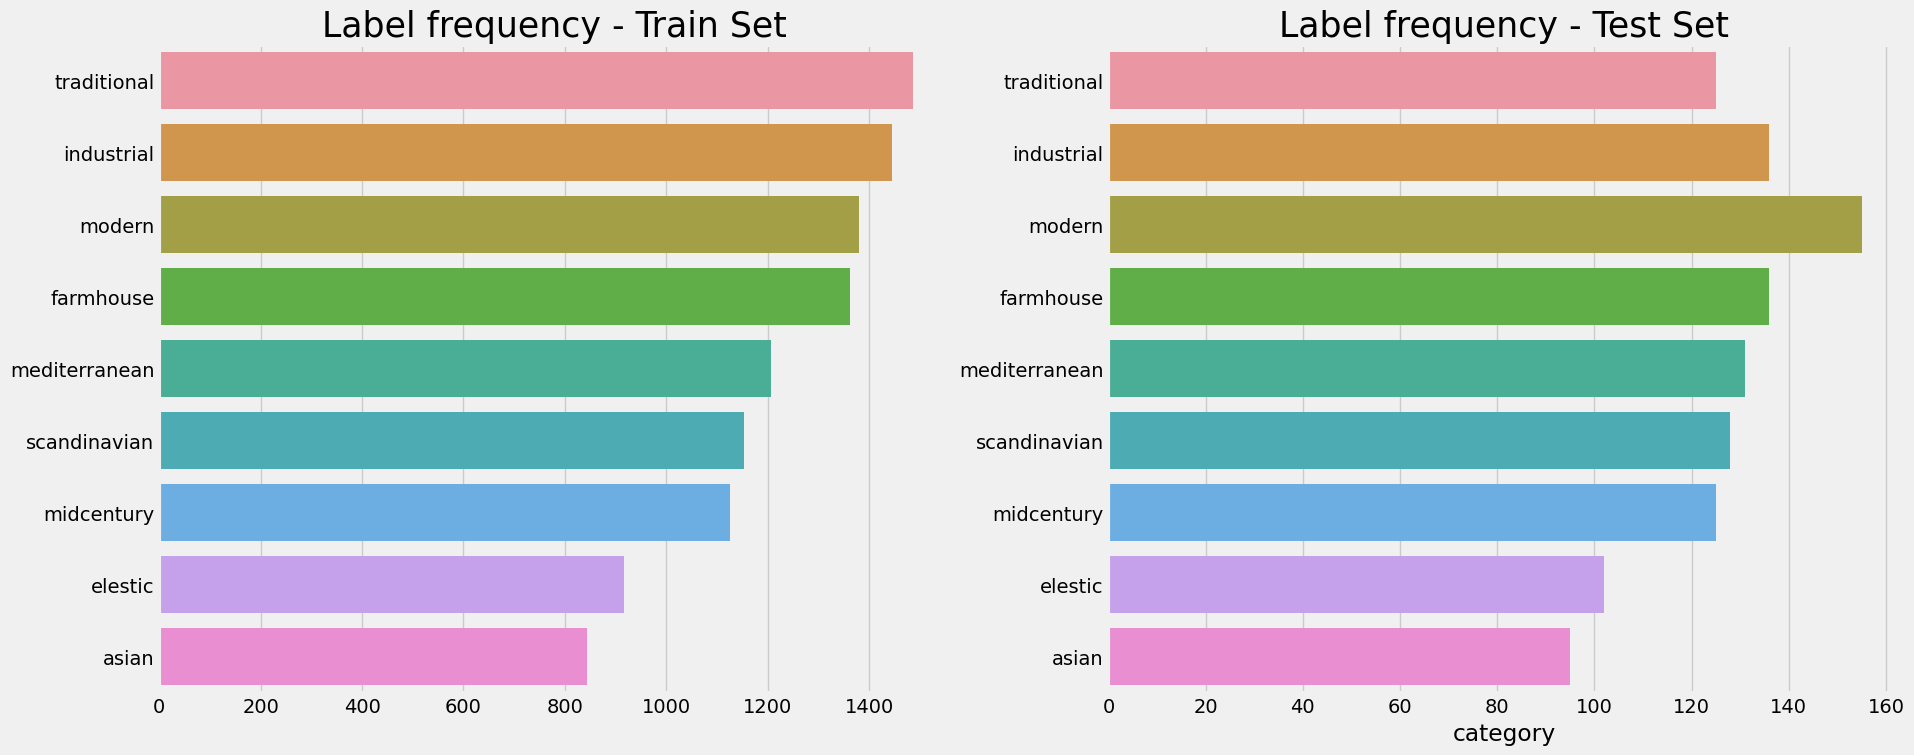

<Figure size 500x600 with 0 Axes>

In [15]:
# Get label frequencies in descending order
label_freq = df_train['category'].value_counts().sort_values(ascending=False)
label_freq_test = df_test['category'].value_counts().sort_values(ascending=False)

# # Bar plot
style.use("fivethirtyeight")
fig, axes = plt.subplots(1,2, figsize= (20,8))
plt.figure(figsize=(5,6))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index, ax=axes[0])
axes[0].set_title("Label frequency - Train Set", fontsize=25) 
axes[0].set_xlabel("")
sns.barplot(y=label_freq_test.index.values, x=label_freq_test, order=label_freq.index, ax=axes[1])
axes[1].set_title("Label frequency - Test Set", fontsize=25) 
axes[1].set_ylabel("");

# Load images

In [16]:
import tensorflow as tf


In [17]:
import tensorflow_datasets as tfds

In [18]:
# Parameters for Loading Data
batch_size = 32
img_height = 250
img_width = 250


## Load - Train data

In [19]:
# Train data directory
train_data_path = os.path.join("..","raw_data","living-room-categories","train_data" )

# Adjustments for loading

# Train Data
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10921 files belonging to 9 classes.
Using 8737 files for training.


2022-09-07 23:17:28.118840: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-07 23:17:28.118885: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-07 23:17:28.118903: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-G7K3M40P): /proc/driver/nvidia/version does not exist
2022-09-07 23:17:28.120298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
class_names = train_ds.class_names
print(class_names)

['asian', 'elestic', 'farmhouse', 'industrial', 'mediterranean', 'midcentury', 'modern', 'scandinavian', 'traditional']


In [21]:
# One hot encode the y
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y,9)))

## Load Validataion Data

In [22]:
# Train data directory - is same data as Training data
train_data_path = os.path.join("..","raw_data","living-room-categories","train_data" )

# Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10921 files belonging to 9 classes.
Using 2184 files for validation.


In [23]:
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y,9)))

## Load Test Data

In [24]:
# Test data directory
data_path_test = os.path.join("..","raw_data","living-room-categories","test_data")


# Test Data
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_path_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1133 files belonging to 9 classes.


In [25]:
# One hot encode the y
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y,9)))

In [26]:
# Split the Test data in X and y - Just for checking
#for X_test, y_test in test_ds:
#    X_test = X_test
#    y_test = y_test


In [27]:
#X_test.shape

In [28]:
#y_test.shape

In [29]:
# Check the shape - Just for checking
#for image_batch, labels_batch in test_ds:
#  print(image_batch.shape)
#  print(labels_batch.shape)
#  break

## Load Data Faster

In [30]:
# Fetch more to make it faster
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Visualize data

2022-09-07 23:17:33.861433: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


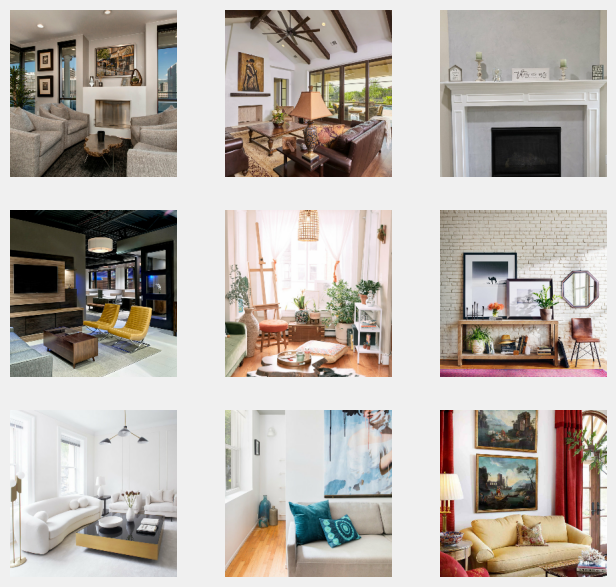

In [31]:
# without category title since they are onehot encoded at this stage
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

# Base line model

In [34]:
# Train a simple model

num_classes = 9

model_bl = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(9, activation="softmax")
])

In [32]:
opt = optimizers.Adam(learning_rate=1e-4)
model_bl.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [33]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)
history_bm = model_bl.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10, 
                    batch_size=32, 
                    callbacks=[es])



Epoch 1/10
129/129 [==============================] - 33s 245ms/step - loss: 2.1667 - accuracy: 0.1380 - val_loss: 2.1143 - val_accuracy: 0.1668
Epoch 2/10
129/129 [==============================] - 30s 231ms/step - loss: 2.0617 - accuracy: 0.2192 - val_loss: 2.0442 - val_accuracy: 0.1961
Epoch 3/10
129/129 [==============================] - 29s 229ms/step - loss: 1.9826 - accuracy: 0.2712 - val_loss: 2.0165 - val_accuracy: 0.2420
Epoch 4/10
129/129 [==============================] - 29s 229ms/step - loss: 1.9171 - accuracy: 0.3058 - val_loss: 2.0142 - val_accuracy: 0.2390
Epoch 5/10
129/129 [==============================] - 29s 227ms/step - loss: 1.8472 - accuracy: 0.3387 - val_loss: 2.0084 - val_accuracy: 0.2449
Epoch 6/10
129/129 [==============================] - 29s 227ms/step - loss: 1.7648 - accuracy: 0.3748 - val_loss: 2.0026 - val_accuracy: 0.2468
Epoch 7/10
129/129 [==============================] - 29s 226ms/step - loss: 1.6773 - accuracy: 0.4162 - val_loss: 2.0179 - val_ac

## Evaluate Baseline score

In [ ]:
# On test data
model_bl.evaluate(test_ds)

#or separate X and y
#model.evaluate(y_base_pred, y_test)

In [ ]:
# to do - evaluate on test set

In [42]:
# Baseline
val_accuracy = max(history_bm.history["val_accuracy"])
val_accuracy

0.2663414776325226

## Predict Y

In [62]:
# Evaluate - Not sure how to get data to precit and evaluate yet
y_base_pred = model.predict(X_test)

18/18 [==============================] - 1s 64ms/step


In [67]:
y_base_pred[1]

array([0.00618056, 0.02233169, 0.03701498, 0.00218411, 0.31780878,
       0.05955791, 0.0121111 , 0.47937867, 0.06343221], dtype=float32)

# ResNet50 - model

## Prepocessing

In [32]:
# Using the Resnet preprocessing function
train_ds_proc = train_ds.map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x), y))
val_ds_proc = val_ds.map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x), y))
test_ds_proc = test_ds.map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x), y))

In [33]:
# Load the model
def load_model():
      
    # Have to change img_arr
    model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=9
)  
    return model

In [34]:
# Set to nontrainable
def set_nontrainable_layers(model):
    model.trainable = False
    return model

### Set Structure of model

In [35]:
# Build the complete model

def build_model():
    # Define the layers
    base_model = load_model()
    base_model = set_nontrainable_layers(base_model)
    flattening_layer = layers.GlobalAveragePooling2D()
    dense_layer = layers.Dense(100, activation='relu')
    prediction_layer = layers.Dense(9, activation='softmax')


    # Here is the pipeline
    model_rn = Sequential([
      base_model,
      flattening_layer,
      dense_layer,
      prediction_layer
    ])
    return model_rn

In [36]:
model_rn = build_model()
model_rn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dense_1 (Dense)             (None, 9)                 909       
                                                                 
Total params: 23,793,521
Trainable params: 205,809
Non-trainable params: 23,587,712
_________________________________________________________________


### Compile

In [37]:
def compile_model(model):
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

### Fit the model

In [38]:
# Build and compile model
model_rn = build_model()
model_rn = compile_model(model_rn)

In [39]:
# Model input
epochs = 50
batch_size = 32
patience = 5

In [40]:
# Fit model as complete function
def fit_model(train_ds_proc, val_ds_proc, model_rn, epochs, batch_size, patience):

    es = EarlyStopping(monitor = 'val_accuracy',
                       mode = 'max',
                       patience = patience,
                       verbose = 1,
                       restore_best_weights = True)

    history_rn = model_rn.fit(train_ds_proc,
                        validation_data=val_ds_proc,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[es])
    return history_rn

In [41]:
%%time

# Fit the model
history_rn = fit_model(train_ds_proc, val_ds_proc, model_rn, epochs, batch_size, patience)

Epoch 1/50
274/274 [==============================] - 570s 2s/step - loss: 1.8135 - accuracy: 0.3441 - val_loss: 1.6149 - val_accuracy: 0.4281
Epoch 2/50
274/274 [==============================] - 516s 2s/step - loss: 1.4780 - accuracy: 0.4765 - val_loss: 1.5014 - val_accuracy: 0.4803
Epoch 3/50
274/274 [==============================] - 476s 2s/step - loss: 1.3588 - accuracy: 0.5207 - val_loss: 1.4526 - val_accuracy: 0.4904
Epoch 4/50
274/274 [==============================] - 459s 2s/step - loss: 1.2792 - accuracy: 0.5531 - val_loss: 1.4243 - val_accuracy: 0.4986
Epoch 5/50
274/274 [==============================] - 459s 2s/step - loss: 1.2167 - accuracy: 0.5790 - val_loss: 1.4010 - val_accuracy: 0.5027
Epoch 6/50
274/274 [==============================] - 461s 2s/step - loss: 1.1629 - accuracy: 0.6018 - val_loss: 1.3846 - val_accuracy: 0.5096
Epoch 7/50
274/274 [==============================] - 459s 2s/step - loss: 1.1163 - accuracy: 0.6216 - val_loss: 1.3741 - val_accuracy: 0.5119

In [42]:
history_rn.history

{'loss': [1.813537359237671,
  1.4779767990112305,
  1.358803629875183,
  1.2792483568191528,
  1.2167037725448608,
  1.1629393100738525,
  1.116314172744751,
  1.0737484693527222,
  1.0329471826553345,
  0.9961891174316406,
  0.960477352142334,
  0.9268569350242615,
  0.8946828842163086,
  0.8638061881065369,
  0.8342392444610596,
  0.8049325942993164],
 'accuracy': [0.3440540134906769,
  0.47647935152053833,
  0.5206592679023743,
  0.5530502200126648,
  0.5790317058563232,
  0.6018084287643433,
  0.6216092705726624,
  0.637861967086792,
  0.6538857817649841,
  0.6685361266136169,
  0.6831864714622498,
  0.6980656981468201,
  0.7105413675308228,
  0.7224447727203369,
  0.7361794710159302,
  0.746709406375885],
 'val_loss': [1.614905834197998,
  1.5013948678970337,
  1.4526417255401611,
  1.424283742904663,
  1.4010283946990967,
  1.3845793008804321,
  1.3741241693496704,
  1.3635190725326538,
  1.3580751419067383,
  1.3530640602111816,
  1.348912000656128,
  1.3448030948638916,
  1.34

In [43]:
model_rn

### Evaluate Model

In [44]:
# does work

model_rn.evaluate(test_ds_proc)

36/36 [==============================] - 48s 1s/step - loss: 1.4541 - accuracy: 0.4925


[1.454082727432251, 0.4924978017807007]

### Plot history

In [45]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

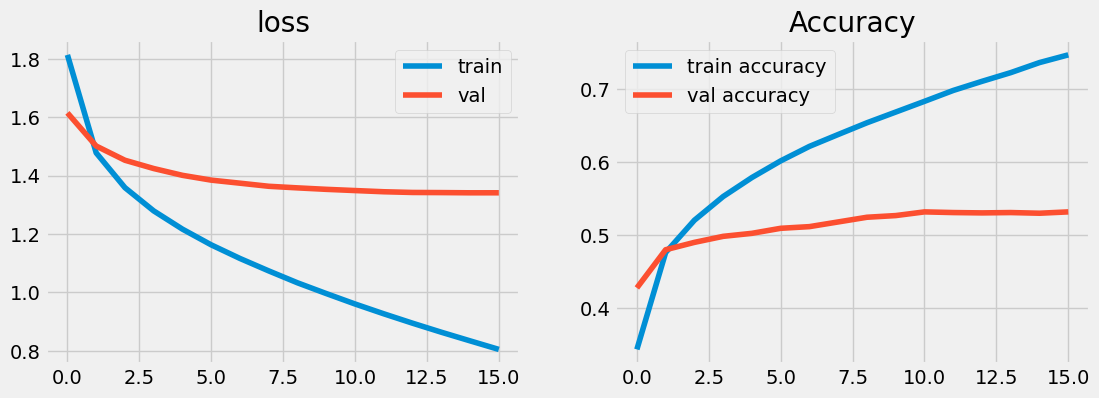

In [46]:
plot_history(history_rn)

### Save the model

In [47]:
# Path to save all
model_save_path = os.path.join("..","saved-models")
model_save_path

'../saved-models'

In [48]:
def save_model(model: Model = None,
               params: dict = None,
               metrics: dict = None,
              model_save_path = model_save_path) -> None:
    """
    persist trained model, params and metrics
    """

    timestamp = time.strftime("%Y%m%d-%H%M%S")

    print(Fore.BLUE + "\nSave model to local disk..." + Style.RESET_ALL)

    # save params
    if params is not None:
        params_path = os.path.join(model_save_path, "params", timestamp + ".pickle")
        print(f"- params path: {params_path}")
        with open(params_path, "wb") as file:
            pickle.dump(params, file)

    # save metrics
    if metrics is not None:
        metrics_path = os.path.join(model_save_path, "metrics", timestamp + ".pickle")
        print(f"- metrics path: {metrics_path}")
        with open(metrics_path, "wb") as file:
            pickle.dump(metrics, file)

    # save model
    if model is not None:
        model_path = os.path.join(model_save_path, "models", timestamp)
        print(f"- model path: {model_path}")
        model.save(model_path)

    print("\n✅ data saved locally")

    return None

In [49]:
# Compute the validation metric (min val mae of the holdout set)
metrics = dict(mae=np.min(history_rn.history['val_accuracy']))

# Save Parameter
params = dict(
    learning_rate=1e-4,
   batch_size=batch_size,
   patience=20)


In [50]:
# Save the model
save_model(model_rn, params=params, metrics=metrics, model_save_path=model_save_path)


Save model to local disk...
- params path: ../saved-models/params/20220908-012417.pickle
- metrics path: ../saved-models/metrics/20220908-012417.pickle
- model path: ../saved-models/models/20220908-012417


INFO:tensorflow:Assets written to: ../saved-models/models/20220908-012417/assets


INFO:tensorflow:Assets written to: ../saved-models/models/20220908-012417/assets



✅ data saved locally


### Load model

In [45]:
model_save_path = os.path.join("..","saved-models")

In [46]:
def load_model(save_copy_locally=False,model_save_path=model_save_path):
    """
    load the latest saved model, return None if no model found
    """
    print(Fore.BLUE + "\nLoad model from local disk..." + Style.RESET_ALL)

    # get latest model version
    model_directory = os.path.join(model_save_path, "models")

    results = glob.glob(f"{model_directory}/*")
    if not results:
        return None

    model_path = sorted(results)[-1]
    print(f"- path: {model_path}")

    model = models.load_model(model_path)
    print("\n✅ model loaded from disk")

    return model


In [47]:
# Load model
model_loaded = load_model(model_save_path=model_save_path)


Load model from local disk...
- path: ../saved-models/models/20220904-204849


2022-09-06 12:18:08.238843: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



✅ model loaded from disk


In [48]:
model_loaded

# Predict for new picture

In [49]:
# Path of new image
pic_name = "scan2.jpg"
img_path = os.path.join("..","raw_data", "test-pics",pic_name )
img_path

'../raw_data/test-pics/scan2.jpg'

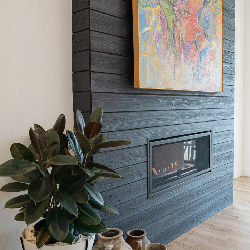

In [50]:
img_pic = load_img(path=img_path, color_mode="rgb",target_size=(250,250))
X_new = img_to_array(img_pic).astype("int").reshape(1,250,250,3)
img_pic

In [51]:
# Preprocess X
X_new_proc = tf.keras.applications.resnet50.preprocess_input(X_new)
X_new_proc.shape

(1, 250, 250, 3)

In [52]:
# predict with loaded model
y_new = model_loaded.predict(X_new_proc)

1/1 [==============================] - 1s 611ms/step


In [53]:
# Result with with loaded model
prediction = pd.DataFrame(y_new, columns=class_names)
prediction

,asian,elestic,farmhouse,industrial,mediterranean,midcentury,modern,scandinavian,traditional
0,0.00369,0.006775,0.122512,0.489883,0.00024,0.107404,0.090345,0.176788,0.002362


In [97]:
# predict with current model
#y_new = model_rn.predict(X_new_proc)

In [98]:
# Result with current model
#prediction = pd.DataFrame(y_new, columns=class_names)
#prediction

In [54]:
# Top categoiren sorted
categories_dict= {0:"asian", 1:"elestic", 2: "farmhouse", 3: "industrial", 4: "mediterranean", 
                  5:"midcentury", 6:"modern", 7:"scandinavian", 8: "traditional" }
pred_dict = {}
counter = 0
for value in y_new[0]:
    cat_name = categories_dict[counter]
    pred_dict[cat_name] = value
    counter +=1


In [55]:
# Sorted results
pred_dict_sorted = dict(sorted(pred_dict.items(), key=lambda x: x[1],reverse=True))
pred_dict_sorted

{'industrial': 0.48988292,
 'scandinavian': 0.17678805,
 'farmhouse': 0.12251218,
 'midcentury': 0.10740434,
 'modern': 0.09034547,
 'elestic': 0.006775293,
 'asian': 0.0036900342,
 'traditional': 0.0023617062,
 'mediterranean': 0.0002399584}

In [56]:
# Just show top X
top_x = 3
i = 0
top_pred_dict = {}
for key, value in pred_dict_sorted.items():
    if i < top_x:
        top_pred_dict[key] = value
        i +=1
    else:
        break

top_pred_dict

{'industrial': 0.48988292, 'scandinavian': 0.17678805, 'farmhouse': 0.12251218}

In [58]:
for key in top_pred_dict.keys():
    print(key)

industrial
scandinavian
farmhouse


In [59]:
[key for key in top_pred_dict.keys()]

['industrial', 'scandinavian', 'farmhouse']

# Check Performance

## Evaluate

## Evaluate model

In [10]:
# To do 

# Get the probablities for the predictions

In [102]:
# To do

# Data augmentation

In [ ]:
# Maybe later if time

# Optimize Model hyperparameters

In [ ]:
# Grid search
# Auto optimization tool
# 

In [68]:
top_desings_string = ['midcentury', 'industrial']

In [61]:
cat = {"a": [1,2,3], "b": [4,5,6]}

In [63]:
cat["a"][:2]

[1, 2]

In [64]:
cat_style_adj = {"scandinavian": ["light", "functional", "organic"],
                     "industrial" : ["dark", "casual", "industrial"],
                     "farmhouse" : ["rustic", "oldfashioned", "charming"],
                     "midcentury": ["dull", "retro", "metallic"],
                     "modern" : ["clean", "rectilinear", "modern"],
                     "elestic": ["bright", "boho", "vintage"],
                     "asian" : ["ink", "asian", "shiny"],
                     "traditional" : ["neutral", "classic", "solid"],
                     "mediterranean" : ["colorful", "mediterranean", "chic"]}

In [67]:
for key, value in cat_style_adj.items():
    print(key, value[1])

scandinavian functional
industrial casual
farmhouse oldfashioned
midcentury retro
modern rectilinear
elestic boho
asian asian
traditional classic
mediterranean mediterranean


In [75]:
num_per_style = 2

In [78]:
cat_style_adj = {"scandinavian": ["light", "functional", "organic"],
                 "industrial" : ["dark", "casual", "industrial"],
                 "farmhouse" : ["rustic", "oldfashioned", "charming"],
                 "midcentury": ["dull", "retro", "metallic"],
                 "modern" : ["clean", "rectilinear", "modern"],
                 "elestic": ["bright", "boho", "vintage"],
                 "asian" : ["ink", "asian", "shiny"],
                 "traditional" : ["neutral", "classic", "solid"],
                 "mediterranean" : ["colorful", "mediterranean", "chic"]}

res_list = []
for design in top_desings_string:
    i = 0
    for adj in cat_style_adj[design]:
        if i < num_per_style:
            res_list.append(adj)
            i +=1
res_list

['dull', 'retro', 'dark', 'casual']

In [101]:
final_color_names = ['dark khaki', 'sienna', 'steel blue']
final_adj_style_list = ['dull', 'retro', 'dark', 'casual']

In [92]:
final_color_names.extend(final_adj_style_list)

In [93]:
final_color_names

['dark khaki', 'sienna', 'steel blue', 'dull', 'retro', 'dark', 'casual']

In [86]:
my_list = ['geeks', 'for']
another_list = [6, 0, 4, 1]
my_list.extend(another_list)
print(my_list)


['geeks', 'for', 6, 0, 4, 1]


In [102]:
def string_output(final_color_names, final_adj_style_list):
    # combine to one list
    final_color_names.extend(final_adj_style_list)
    
    res_string = ""
    for word in final_color_names:
        res_string = res_string + " " + word
    
    return res_string

In [103]:
string_output(final_color_names, final_adj_style_list)

' dark khaki sienna steel blue dull retro dark casual'

In [3]:
# tests
pic_theme = None
pic_format = None


In [6]:
pic_theme = "Y"

In [8]:
pic_format = "N"

In [9]:
if (pic_theme is not None) and (pic_format is not None):
    print("Yes")
else:
    print("No")

Yes
